### Contents <a id="top">

#### [Introduction](#intro)
#### [Experimental design](#design)
#### [Import packages and setup muselsl](#setup)
#### [Shuffle sentences and time stimulus events](#shuffle)
#### [Present stimulus](#present)
#### [Analyse data](#analyse)

-------

### Introduction <a id="intro">

In the current experiment, I attempt to measure the N400, an ERP-component usually elicited by an increased load on semantic processing. The N400 is characterized by a negativity typically observable around 400 ms after the occurrence of the stimulus, maximal in amplitude in the central-parietal areas, but otherwise broadly distributed over the scalp. The N400 is sensitive to infrequent as well as contextually unexpected words. Semantic priming (the previous presentation of semantically related words) has been shown to reduce its amplitude. For more details, see [the Wikipedia page for the N400 ERP-component](https://en.wikipedia.org/wiki/N400_(neuroscience)).

Here, I examine the contextual aspect of N400. I hypothesise that people in general tend to expect men and women to have jobs and demonstrate attitudes that are traditionally masculine or feminine, respectively. Therefore, sentences that communicate information deviating from these standards should elicit the N400 response due to difficulties in contextual processing.

<a href="https://www.researchgate.net/figure/N400-and-P600-Components-of-the-ERP_fig1_326606501"><img src="https://www.researchgate.net/profile/Patrick-Ledwidge/publication/326606501/figure/fig1/AS:652287580053505@1532528886461/N400-and-P600-Components-of-the-ERP.png" alt="N400 and P600 Components of the ERP." width="400px"/></a>

(Source of the figure: The Impact of Sports-Related Concussions on the Language System: A Case for Event-Related Brain Potentials - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/N400-and-P600-Components-of-the-ERP_fig1_326606501 [accessed 24 Jun, 2021])

#### [back to top](#top)

------

### Experimental design  <a id="design">

Subjects are presented sentences word-by-word on a screen, with the following grammatical structure:

$The$ $<subject>$ $<adverb>$ $<predicate>$ $<\textit{possessive gender pronoun}>$ $<object>$.

Some of these sentences express traditional relationships between the subject's gender and their professional activities, such as "*The doctor carefully prepared his tools.*", while others contain somewhat unusual phenomena, e.g. "*The engineer tiredly cleaned her glasses.*" I hypothesize that these latter sentences - due to their surprising gender-related content (e.g. engineering is usually perceived by the general public as a masculine occupation) - elicit an N400 component that differs significantly from the responses potentially elicited by convential sentences.

Subjects of the experiment are all members of Rajk College for Advanced studies. Their native language is Hungarian, but they are practised English speakers, which is important as the sentences are presented in English. (I couldn't do the experiment in Hungarian due to the lack of gender-specific pronouns.)

For stimulus presentation, I use the [`PsychoPy`](https://www.psychopy.org/index.html) package. I record neural activity with the help of the [Muse headband](https://choosemuse.com/) and use the [`muse-lsl`](https://github.com/alexandrebarachant/muse-lsl) package to visualize the EEG-recording in real time to adjust the headband and stabilize the signal. The muse headband has 2 frontal and 2 temporal electrodes, which is not ideal to measure the centro-parietally concentrated N400 component, but I hope that its extended nature allows me to catch some of the signal. Nevertheless, due to the simplified technology of this device and the potential noise disrupting the experimental conditions, the current study has its severe limitations.

#### [back to top](#top)

------

### Import packages and setup muselsl  <a id="setup">

In [ ]:
import psychopy
from psychopy import visual, core
from muselsl import view

In [1]:
import time, datetime
import glob

import numpy as np
import pandas as pd
import random

import matplotlib
from matplotlib import pyplot as plt

#### record stream from command line

The EEG signal is recorded for $150$ seconds to fully encorporate the $\sim 104$ s duration of the stimulus presentation.

```muselsl stream -a 00:55:DA:B5:85:4C```

```muselsl record -d 150 -f "./MEGAsync/Academics/ELTE_CCNM/Semester 4./Programming/output/eeg_<subject>.csv"```

#### view real-time recording

In [ ]:
view(version=3, backend="nbAgg", figure='15x10')

#### [back to top](#top)

----------

### Shuffle sentences and time stimulus events  <a id="shuffle">

Sentences are presented in a random order that differs for each subject. Stimulus presentation time is adjusted to the framerate: each word is shown for 20 frames, with a break lasting 5 frames within and 100 frames between sentences.

In [2]:
with open("sentences.txt", "r") as f:
    sentences = f.read().split("\n")

In [3]:
def construct_stimulus(sentences, word_pres_dur=20, within_break=5, between_break=100):
    """
    Creates a dataframe, each row of which contain information about
    an individual frame during stimulus presentation.

    Parameters
    ----------
    sentences: list of strings
        The sentences to be presented.
    word_pres_dur: int, optional
        Specifies the duration of presentation for each word in frames. Default is 20.
    within_break: int, optional
        Specifies the duration of within-sentence breaks between words in frames. Default is 5.
    between_break: int, optional
        Specifies the duration of breaks between sentences in frames. Default is 100.

    Returns
    ----------
    out: pandas.core.frame.DataFrame
        Dataframe containing the following columns:
        - word: str, presented word
        - sentence: int, sentence ID
        - change: bool, indicates the appearance of a new word
        - time: None, column to store exact presentation times during stimulus presentation
    """

    shuffled_indices = random.sample(list(range(len(sentences))), len(sentences))

    return (
        pd.concat(
            [
                pd.concat(
                    [
                        pd.DataFrame([word] * word_pres_dur, columns=["word"]).append(
                            pd.DataFrame([{"word": ""} for k in range(within_break)])
                        )
                        for word in sentences[i].split(" ")
                    ]
                )
                .append(pd.DataFrame([{"word": ""} for k in range(between_break)]))
                .assign(sentence=i)
                for i in shuffled_indices
            ]
        )
        .reset_index(drop=True)
        .assign(change=lambda df: df["word"].ne(df["word"].shift()), time=None)
    )

#### [back to top](#top)

-------

### Present stimulus  <a id="present">

In [17]:
subject = "dani"

In [18]:
stim_df = construct_stimulus(sentences)

In [19]:
win = visual.Window([500, 500])
message = visual.TextStim(win)

# iterate over frames
for i, r in stim_df.iterrows():

    # set the stimulus to the next word
    if r["change"]:
        message.text = r["word"]

    # show the current word, unless it's a within-stimulus interval
    if r["word"]:
        message.draw()

    # record exact timing of each frame
    stim_df.loc[i, "time"] = time.time()

    # do not enter next iteration until the frame is refreshed
    win.flip()

win.close()
pd.DataFrame(stim_df).to_parquet(f"output/stim_data_{subject}.parquet")

2114.4727 	WARNING 	Monitor specification not found. Creating a temporary one...


#### [back to top](#top)

-----------

### Analyse data  <a id="analyse">

In [2]:
type_dict = {
    k: v
    for k, v in enumerate(
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]
    )
}

In [3]:
subjects = [
    f.split("_")[1].replace(".csv", "") for f in sorted(glob.glob("output/*.csv"))
]

In [4]:
eeg_recordings = {
    s: pd.read_csv(f"output/eeg_{s}.csv").drop("Right AUX", axis=1) for s in subjects
}
stimuli = {s: pd.read_parquet(f"output/stim_data_{s}.parquet") for s in subjects}

In [5]:
sample = (
    stimuli[subjects[0]]
    .loc[lambda df: df["word"].isin(["his", "her"]) & df["change"]]
    .assign(stim_type=lambda df: df["sentence"].apply(lambda s: type_dict[s]))
    .reset_index(drop=True)
    .pipe(
        lambda df: df.loc[:, ["stim_type"]].merge(
            df.apply(
                lambda r: eeg_recordings[subjects[0]]
                .loc[
                    lambda df2: (r["time"] <= df2["timestamps"])
                    & (df2["timestamps"] < r["time"] + 0.5),
                    "TP9",
                ]
                .reset_index(drop=True),
                axis=1,
            ),
            left_index=True,
            right_index=True,
        )
    )
    .groupby("stim_type")
    .mean()
)

<IPython.core.display.Javascript object>


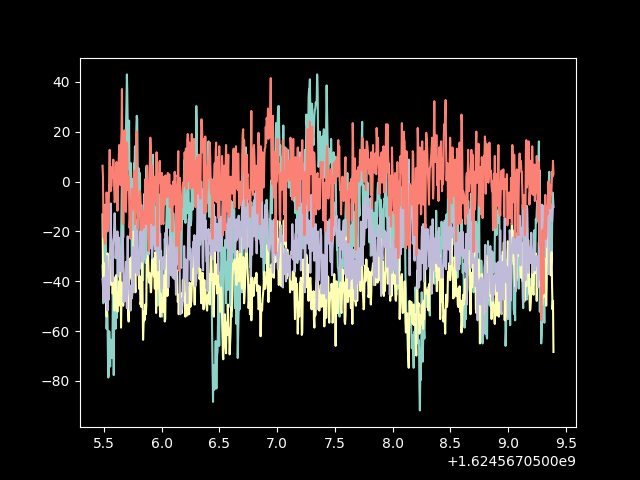

In [23]:
for c in data.columns[1:]:
    
    plt.plot(*data.loc[:1000, ["timestamps", c]].values.T)

#### [back to top](#top)

----------